In [2]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Essentials
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches
%matplotlib widget
from datetime import timedelta

#Oceanography tools
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
from iapws import iapws95
from physoce import tseries as ts 

#Scipy
from scipy import stats
from scipy.stats import chi2 
from scipy.stats.distributions import  t
from scipy import signal
from scipy.signal import welch 
from scipy.signal import periodogram
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.integrate import quad_vec
from scipy.special import gamma

In [8]:
#Import data
#advFilepath = 'Dissipation/burst76.nc'
advFilepath = 'ADV/adv1_final.nc'
tempFilepath = 'Temperature/temp_final.nc'

ADVdata = xr.open_dataset(advFilepath)
TEMPdata = xr.open_dataset(tempFilepath)

In [13]:
ADVdata.J33.where(ADVdata.burst.isin(76), drop=True)

<xarray.DataArray 'J33' (burst: 1)>
array([0.03126335])
Coordinates:
  * burst    (burst) int64 76
Attributes:
    Description:  The wavespace integral used in equation A13 of Gerbi et al....
    Direction:    Vertical

In [17]:
ADVdata = ADVdata.sel(time = slice('2022-08-05T12:40:00.000000000','2022-08-05T12:59:59.968750000'),
            time_sen = slice('2022-08-05T12:40:00.000000000','2022-08-05T12:59:59.968750000'),
            time_start = slice('2022-08-05T12:40:00.000000000','2022-08-05T12:59:59.968750000'),
            burst = 76)

In [18]:
#Take a look at what's offered in the datasets
ADVdata
#TEMPdata

<xarray.Dataset>
Dimensions:                 (time_start: 1, time_sen: 1198, time: 38400)
Coordinates:
  * time                    (time) datetime64[ns] 2022-08-05T12:40:00 ... 202...
  * time_sen                (time_sen) datetime64[ns] 2022-08-05T12:40:02 ......
  * time_start              (time_start) datetime64[ns] 2022-08-05T12:40:00
    burst                   int64 76
Data variables: (12/64)
    BurstCounter            (time_start) int64 ...
    NoVelSamples            (time_start) int64 ...
    ErrorCode               (time_sen) int64 ...
    StatusCode              (time_sen) int64 ...
    BatVolt                 (time_sen) float64 ...
    SoundSpeed              (time_sen) float64 ...
    ...                      ...
    EastRaw                 (time) float64 ...
    NorthRaw                (time) float64 ...
    UpRaw                   (time) float64 ...
    J11                     float64 ...
    J22                     float64 ...
    J33                     float64 ...
Attributes: (12/53)
    Creator:                                               Logan A. Grady
    Contact information:                                   logan.grady@sjsu.edu
    Description:                                           Data where gaps wi...
    Lat:                                                   36.56195999999164
    Lon:                                                   -121.94174126537672
    Pressure sensor height (m):                            0.58
    ...                                                    ...
    SnrCutoff:                                             10
    AngleCutoff:                                           0.1
    Theta:                                                 -148.9786176963419
    despike_lp_freq (hz):                                  0.05
    despike_cutoff_expansion_fraction:                     0.01
    despike_cutoff_expansion_densityChange_end_condition:  0.95

### Selecting good data
Before any estimates are made, the burst in question is vetted for is ratio of 'bad data'
- During the data qc process, velocities that are considered "spikes" are replaced with the last non-spike <br> 
data point as per the methods in Wheeler and Giddings (2023)
- Data points with a beam correlation < 60% and an SNR <10 dB are also removed
- The gaps created by the correlation and SNR tests are linearly interpolated if they are <= 1 second or averaged <br>
over the duration of the gap if it is >1 second as per the methods in Feddersen (2010)
- The points that have been despiked, interpolated, or averaged are labeled as "unoriginal points", and the ratio of <br>
unoriginal points to normal points within a burst shouldn't be too high
- This method excludes any data bursts with a bad data ratio >.2, which pertains to 4 minutes of data

In [19]:
#Make a copy of the dataset to prevent accidental modification of original data
ADVds = ADVdata.copy(deep=True)
TEMPds = TEMPdata.copy(deep=True)

#Create an array of bursts to call that are below the bad data threshold
badDataRatioCutoff = .25
goodBursts = ADVds.burst.where(ADVds.UpOrigRatio < badDataRatioCutoff, drop=True) #ds.dUp is the bad data ratio for the vertical velocity

#This demo only uses burst 76, which is a "good" burst, but this function would drop
#all bursts above the threshold and make a list of the remaining good bursts in the dataset
burstList = np.unique(int(goodBursts))

### Setting parameters for the function
The epsilon estimate algorithm requires a few parameters in order to run

In [57]:
#Instrument data
fs = ADVds.attrs['Sampling rate'] #The sampling rate of the instrument (32 Hz in this case)
ZpOffset = ADVds.attrs['Pressure sensor height (m)'] #Height of ADV pressure sensor off the seafloor (m)
ZvOffset = ADVds.attrs['Velocity sample height (m)'] #Height of velocity measurement off the seafloor (m)

#Number of data points within the burst (must be consistent for all bursts)
n = ADVds.attrs['Samples per burst']

#The minimum length of the inertial subrange that the algorithm will estimate
minISRrange = 1 * (2*np.pi) #1 Hz converted to radian frequency (rad/s)

#The estimated frequency at which noise dominates the velocity spectrum, which is about 3.1 Hz in this case
fNoise = 3.5 * (2*np.pi) #3.5 Hz converted to radian frequency (rad/s)

#The type of filter window used for the spectra calculation
window = 'hann' #Uses window arguments for scipy.welch

#The length of the segment size used in the filter window
nperseg = 60 * fs #This corresponds to a 60 second window, which is 1920 data points

#Initialize arrays to hold all variables generated by the dataset
fullSw = np.empty((len(burstList),int(nperseg/2)+1)) #Full spectrum of velocity components
fullSu = np.empty((len(burstList),int(nperseg/2)+1))
fullSv = np.empty((len(burstList),int(nperseg/2)+1))
fullSp = np.empty((len(burstList),int(nperseg/2)+1)) #Converted pressure spectrum
isrUpper = np.empty(len(burstList)) #Upper boundary of inertial subrange (ISR)
isrLower = np.empty(len(burstList)) #Lower boundary of ISR
Mu = np.empty(len(burstList)) #Slope of ISR fit
MuErr = np.empty(len(burstList)) #Error of slope
Int = np.empty(len(burstList)) #Intercept of ISR fit
IntErr = np.empty(len(burstList)) #Error of slope
KolInt = np.empty(len(burstList)) #Intercept of -5/3 fit
KolIntErr = np.empty(len(burstList)) #Error of -5/3 intercept
FitMisfit = np.empty(len(burstList)) #Misfit between ISR slope and -5/3
maxSw = np.empty(len(burstList)) 
minSw = np.empty(len(burstList))
Noise = np.empty(len(burstList)) #Magnitude of noise floor
wavePeak = np.empty(len(burstList)) #Magnitude peak wave band frequency

#Initialize arrays to hold all dissipation estimates and eps variables
epsMag = np.empty(len(burstList)) #Mean of eps values over isr
epsErr = np.empty(len(burstList)) #Error in eps estimate
epsFitInt = np.empty(len(burstList)) # Intercept of eps estimate linear regression (LR) model
epsFitSlope = np.empty(len(burstList)) #LR Slope
epsFitR2val = np.empty(len(burstList)) #LR R2-value
epsFitPval = np.empty(len(burstList)) #LR P-value
epsFitSlopeErr = np.empty(len(burstList)) #Error of LR slope
epsFitIntErr = np.empty(len(burstList)) #Error of LR intercept

#Initialize array to hold Ozmidov and Komogorov length scale values once eps has been estimated
LenOz = np.empty(len(burstList))
LenKol = np.empty(len(burstList))

J33 = np.array([ADVds.J33.where(ADVds.burst.isin(burstList), drop=True)]) # Wavenumber space integral
dUp = np.array([ADVds.UpOrigRatio.where(ADVds.burst.isin(burstList), drop=True)]) # Ratio of bad datapoints within the burst

In [58]:
#In the real function, a large for loop is set up to iterate over all of the bursts in 'burstList'
#Since we're only testing one burst here, I'm creating this substitude array 'b', so that the function
#still works later in the code
b = np.array((0, 76), dtype=int)

### REAL CODE ###
for b in enumerate(burstList):
    print('Evaluating burst '+str(b[0]+1)+' of '+str(len(burstList)))

    #Select the burst number
    burstNumber = b[1] #Pertains to 76

    #Retrieve variables from the burst time period
    burstTime = ADVds.time.where(ADVds.BurstNum.isin(burstNumber)).dropna(dim = 'time', how = 'all') #Isolated time coordinate for the burst
    burstPressure = ADVds.Pressure.sel(time=slice(burstTime[0],burstTime[-1])) * 10000 #ADV pressure within timeframe converted to Pascals
    burstTemp =  ADVds.Temperature.sel(time_sen=slice(burstTime[0],burstTime[-1])) #ADV temperature within timeframe
    burstRho = TEMPds.Rho.sel(time=slice(burstTime[0],burstTime[-1])) #Density profiles during timeframe

    #Retreive the U,V,Vertical components of velocity from the burst
    burstUp = ADVds.Up.where(ADVds.BurstNum.isin(burstNumber)).dropna(dim = 'time', how = 'all')
    burstU = ADVds.Primary.where(ADVds.BurstNum.isin(burstNumber)).dropna(dim = 'time', how = 'all')
    burstV = ADVds.Secondary.where(ADVds.BurstNum.isin(burstNumber)).dropna(dim = 'time', how = 'all')

    #Generate vertical and horizontal velocity spectra using scipy.welch with the previously defined parameters
    Fw, Sw = welch(burstUp, fs=fs, nperseg= nperseg, window='hann', detrend = 'linear') #Vertical velocity spectra
    Fu, Su = welch(burstU, fs=fs, nperseg= nperseg, window='hann', detrend = 'linear') #Horiztonal velocity spectra
    Fv, Sv = welch(burstV, fs=fs, nperseg= nperseg, window='hann', detrend = 'linear')
    #All spectra are linearly detrended to try and account for tidal cycles

    #Spectra are output in units of m^2 s^-2 Hz^-1, so they are converted to radian frequency
    Sw = Sw/(2*np.pi)
    Su = Su/(2*np.pi)
    Sv = Sv/(2*np.pi)

### Defining lower and upper bounds of inertial subrange (ISR)
The algorithm only estimates epsilon within the expected ISR, so boundaries must be set within the spectra
- The upper boundary is determined by the peak frequency of the surface wave spectrum
    - Vertical velocity spectrum is converted to pressure using linear wave theory
    - Function requires k and omega
- The lower boundary is the frequency where noise begins to dominate the spectrum

In [59]:
# Function for estimating k and omega from wave period and total depth using dispersion relationships
def wavedisp(wavper,h):
    """ 
    (omega,k,Cph,Cg) = wavedisp(wavper,h)
    ------------------
    Returns [omega,k,Cph,Cg]

    Inputs (can use arrays): 
            wavper - wave period [s]
            h - water depth [m]
   
    Outputs: 
    omega - angular wave frequency [radians/s]
    k - angular wave number	 [radians/m]
    Cph - phase speed [m/s]
    Cg - group velocity [m/s]
    """

    """ T Connolly 2014
    based on Matlab function wavedisp.m from S Lentz """
    # make sure inputs are arrays
    wavper=np.array(wavper)
    h=np.array(h)
    
    omega = (2*np.pi)/wavper
    g = 9.8
    c = omega**2*h/g
    
    x = np.sqrt(c)
    
    d = 100*np.ones(np.shape(wavper))
    tol = 5.*np.finfo(float).eps
    while (d>tol).any():
        f1=x*np.tanh(x)-c
        f2=x*(1/np.cosh(x))**2+np.tanh(x)
        x=x-f1/f2
        d=np.abs((c-x*np.tanh(x))/c)
    k=x/h
    Cph=omega/k
    Cg=(g*x*(1/np.cosh(x))**2+g*np.tanh(x))/(2*np.sqrt(g*k*np.tanh(x)))
    
    return (omega,k,Cph,Cg)

#Wave period is the spectrum frequency range converted to period (s)
waveper = 1/Fw

#Water depth (H)
Pa = burstPressure.mean() #Mean pressure for the burst in pascals
rhoBar = burstRho.mean().values #Mean density over the duration of the burst
g = -9.81 #Gravity
Zp = Pa / (rhoBar*g) #Depth of the pressure sensor
H = -Zp + ZpOffset #Positive depth of the pressure sensor plus the height of sensor from the seafloor
Zv = -H + ZvOffset #Depth of the velocity transducer

#Wavedisp function calculates omega and k from period and total water depth
omega,k,Cph,Cg = wavedisp(waveper, H)

#Calculate the pressure spectra from the burstPressure data
Fp, Sp = welch(burstPressure, fs = fs, nperseg = nperseg, window='hann', detrend = 'linear') #Detrended pressure spectra
Sp = Sp/(2*np.pi)
# Generate empty arrays for p' and w' values
p_prime = np.empty(len(omega))
w_prime = np.empty(len(omega))

#Use wave dispersion equations to calculate w' and p' for pressure to vertical velocity conversion
for j in range(len(omega)): # For loop iterates over all values of omega
    p_prime[j] = (rhoBar*g)*(np.cosh(k[j]*(Zp+H))/np.cosh(k[j]*H))
    w_prime[j] = (-omega[j])*(np.sinh(k[j]*(Zv+H)))/(np.sinh(k[j]*H))

#The scale factor to multiply the pressure by
scaleFactor = w_prime**2 / p_prime**2

#Calculate the equivalent Sw' spectra from Sp
Sw_prime = Sp * scaleFactor

#Define the lower frequency cutoff as the end of surface gravity wave band
try: #Try statement used in case this function runs into an error
    lfc = argrelextrema(Sw_prime, np.less, order=10)[0][0] - 1
    
except IndexError:
    #Any issue with indexes should yield a default wave cutoff of .5 Hz (pi rad/s)
    #.5 is a conservative estiamte of where the wave band ends, but still preceeds the potential ISR
    lfc = np.where(omega == (np.pi))[0][0]
    
#Define the mean noise floor past the noise frequency cutoff
Fn = np.where(omega == fNoise)[0][0]    #Position of the noise frequency in the omega array
noiseFloor = np.mean(Sw[Fn:])      #Mean of all spectra above Fn is defined as the noise floor

#Define the upper frequency cutoff as the beginning of the noise floor
ufc = Fn

In [ ]:
def epsCalc(ADVdata, TEMPdata, badDataRatioCutoff, selBurstNumbers = None, segLength=None, minimumGap=1, noiseFrequency = 3.1):
    #Make a copy of the dataset to prevent accidental modification of original data
    ADVds = ADVdata.copy(deep=True)
    TEMPds = TEMPdata.copy(deep=True)
    
    #Create an array of bursts to call that are below the bad data threshold
    if selBurstNumbers:
        burstList = np.unique(selBurstNumbers)
    else:
        goodBursts = ADVds.burst.where(ADVds.UpOrigRatio < badDataRatioCutoff, drop=True) #ds.dUp is the bad data ratio for the vertical velocity
        burstList = np.unique(int(goodBursts))
    
    #Call the instrument parameters that are needed for the calculation
    fs = ADVds.attrs['Sampling rate'] #The sampling rate of the instrument (32 Hz in this case)
    ZpOffset = ADVds.attrs['Pressure sensor height (m)'] #Height of ADV pressure sensor off the seafloor (m)
    ZvOffset = ADVds.attrs['Velocity sample height (m)'] #Height of velocity measurement off the seafloor (m)
    n = ADVds.attrs['Samples per burst'] #Number of data points within the burst (must be consistent for all bursts)

    #The minimum length of the inertial subrange that the algorithm will estimate
    minISRrange = minimumGap * (2*np.pi) #1 Hz converted to radian frequency (rad/s)

    #The estimated frequency at which noise dominates the velocity spectrum
    fNoise = noiseFrequency * (2*np.pi)

    #The type of filter window used for the spectra calculation
    window = 'hann' #Uses window arguments for scipy.welch

    #The length of the segment size used in the filter window
    nperseg = segLength
    
    #Initialize arrays to hold all variables generated by the dataset
    fullSw = np.empty((len(burstList),int(nperseg/2)+1)) #Full spectrum of velocity components
    fullSu = np.empty((len(burstList),int(nperseg/2)+1))
    fullSv = np.empty((len(burstList),int(nperseg/2)+1))
    fullSp = np.empty((len(burstList),int(nperseg/2)+1)) #Converted pressure spectrum
    isrUpper = np.empty(len(burstList)) #Upper boundary of inertial subrange (ISR)
    isrLower = np.empty(len(burstList)) #Lower boundary of ISR
    Mu = np.empty(len(burstList)) #Slope of ISR fit
    MuErr = np.empty(len(burstList)) #Error of slope
    Int = np.empty(len(burstList)) #Intercept of ISR fit
    IntErr = np.empty(len(burstList)) #Error of slope
    KolInt = np.empty(len(burstList)) #Intercept of -5/3 fit
    KolIntErr = np.empty(len(burstList)) #Error of -5/3 intercept
    FitMisfit = np.empty(len(burstList)) #Misfit between ISR slope and -5/3
    maxSw = np.empty(len(burstList)) #Magnitude of spectrum at the highest frequency of ISR
    minSw = np.empty(len(burstList)) #Magnitude of spectrum at the lowest frequency of ISR
    Noise = np.empty(len(burstList)) #Magnitude of noise floor
    wavePeak = np.empty(len(burstList)) #Magnitude peak wave band frequency

    #Initialize arrays to hold all dissipation estimates and eps variables
    epsMag = np.empty(len(burstList)) #Mean of eps values over isr
    epsErr = np.empty(len(burstList)) #Error in eps estimate
    epsFitInt = np.empty(len(burstList)) # Intercept of eps estimate linear regression (LR) model
    epsFitSlope = np.empty(len(burstList)) #LR Slope
    epsFitR2val = np.empty(len(burstList)) #LR R2-value
    epsFitPval = np.empty(len(burstList)) #LR P-value
    epsFitSlopeErr = np.empty(len(burstList)) #Error of LR slope
    epsFitIntErr = np.empty(len(burstList)) #Error of LR intercept

    #Initialize array to hold Ozmidov and Komogorov length scale values once eps has been estimated
    LenOz = np.empty(len(burstList))
    LenKol = np.empty(len(burstList))

    J33 = np.array([ADVds.J33.where(ADVds.burst.isin(burstList), drop=True)]) # Wavenumber space integral
    dUp = np.array([ADVds.UpOrigRatio.where(ADVds.burst.isin(burstList), drop=True)]) # Ratio of bad datapoints within the burst
    
    for b in enumerate(burstList):
        print('Evaluating burst '+str(b[0]+1)+' of '+str(len(burstList)))

        #Select the burst number
        burstNumber = b[1] #Pertains to 76

        #Retrieve variables from the burst time period
        burstTime = ADVds.time.where(ADVds.BurstNum.isin(burstNumber)).dropna(dim = 'time', how = 'all') #Isolated time coordinate for the burst
        burstPressure = ADVds.Pressure.sel(time=slice(burstTime[0],burstTime[-1])) * 10000 #ADV pressure within timeframe converted to Pascals
        burstTemp =  ADVds.Temperature.sel(time_sen=slice(burstTime[0],burstTime[-1])) #ADV temperature within timeframe
        burstRho = TEMPds.Rho.sel(time=slice(burstTime[0],burstTime[-1])) #Density profiles during timeframe

        #Retreive the U,V,Vertical components of velocity from the burst
        burstUp = ADVds.Up.where(ADVds.BurstNum.isin(burstNumber)).dropna(dim = 'time', how = 'all')
        burstU = ADVds.Primary.where(ADVds.BurstNum.isin(burstNumber)).dropna(dim = 'time', how = 'all')
        burstV = ADVds.Secondary.where(ADVds.BurstNum.isin(burstNumber)).dropna(dim = 'time', how = 'all')

        #Generate vertical and horizontal velocity spectra using scipy.welch with the previously defined parameters
        Fw, Sw = welch(burstUp, fs=fs, nperseg= nperseg, window='hann', detrend = 'linear') #Vertical velocity spectra
        Fu, Su = welch(burstU, fs=fs, nperseg= nperseg, window='hann', detrend = 'linear') #Horiztonal velocity spectra
        Fv, Sv = welch(burstV, fs=fs, nperseg= nperseg, window='hann', detrend = 'linear')
        #All spectra are linearly detrended to try and account for tidal cycles

        #Spectra are output in units of m^2 s^-2 Hz^-1, so they are converted to radian frequency
        Sw = Sw/(2*np.pi)
        Su = Su/(2*np.pi)
        Sv = Sv/(2*np.pi)
        
        
        waveper = 1/Fw ##Wave period in s
        Pa = burstPressure.mean() #Mean pressure for the burst in pascals
        rhoBar = burstRho.mean().values #Mean density over the duration of the burst
        g = -9.81 #Gravity
        Zp = Pa / (rhoBar*g) #Depth of the pressure sensor
        H = -Zp + ZpOffset #Positive depth of the pressure sensor plus the height of sensor from the seafloor
        Zv = -H + ZvOffset #Depth of the velocity transducer

        #Wavedisp function calculates omega and k from period and total water depth
        omega,k,Cph,Cg = wavedisp(waveper, H)

        #Calculate the pressure spectra from the burstPressure data
        Fp, Sp = welch(burstPressure, fs = fs, nperseg = nperseg, window='hann', detrend = 'linear') #Detrended pressure spectra
        Sp = Sp/(2*np.pi)
        # Generate empty arrays for p' and w' values
        p_prime = np.empty(len(omega))
        w_prime = np.empty(len(omega))

        #Use wave dispersion equations to calculate w' and p' for pressure to vertical velocity conversion
        for j in range(len(omega)): # For loop iterates over all values of omega
            p_prime[j] = (rhoBar*g)*(np.cosh(k[j]*(Zp+H))/np.cosh(k[j]*H))
            w_prime[j] = (-omega[j])*(np.sinh(k[j]*(Zv+H)))/(np.sinh(k[j]*H))

        #The scale factor to multiply the pressure by
        scaleFactor = w_prime**2 / p_prime**2

        #Calculate the equivalent Sw' spectra from Sp
        Sw_prime = Sp * scaleFactor

        #Define the lower frequency cutoff as the end of surface gravity wave band
        try: #Try statement used in case this function runs into an error
            lfc = argrelextrema(Sw_prime, np.less, order=10)[0][0] - 1

        except IndexError:
            #Any issue with indexes should yield a default wave cutoff of .5 Hz (pi rad/s)
            #.5 is a conservative estiamte of where the wave band ends, but still preceeds the potential ISR
            lfc = np.where(omega == (np.pi))[0][0]

        #Define the mean noise floor past the noise frequency cutoff
        Fn = np.where(omega == fNoise)[0][0]    #Position of the noise frequency in the omega array
        noiseFloor = np.mean(Sw[Fn:])      #Mean of all spectra above Fn is defined as the noise floor

        #Define the upper frequency cutoff as the beginning of the noise floor
        ufc = Fn

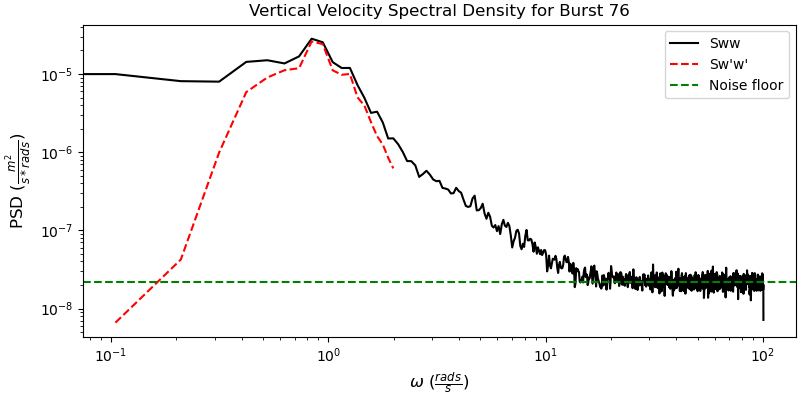

In [60]:
#Check out what the spectrum of vertical velocity looks like
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))

ax.set_title('Vertical Velocity Spectral Density for Burst 76')
ax.loglog(omega, Sw, '-k', label = 'Sww')
ax.loglog(omega[:lfc], Sw_prime[:lfc], '--r', label = "Sw'w'")
ax.axhline(y = noiseFloor, c = 'green', ls = '--', label = 'Noise floor')
ax.set_ylabel(r"PSD ($\frac{m^{2}}{s * rads}}$)", fontsize = 12)
ax.set_xlabel(r"$\omega$ $(\frac{rads}{s})$", fontsize = 12)
ax.legend()

#plt.savefig('Plots/b76Demo_spectra.png')

### Generating possible inertial subranges (ISR)
Determining where the ISR lies is done through an iterative process
- Using the lfc and ufc determined from the previous section, the lower and upper bounds are set
- A for loop generates a list of every single combination of frequencies in the 'omega' array, <br>
but leaves a minimum gap based on the set parameter 'minGap'
- This ensures that the predicted ISR is not too short and prone to drastic changes in spectra <br>
variability during dissipation estimates

In [43]:
#Initialize an array from lfc to ufc to iterate over
startRange = np.arange(lfc, ufc) #This will be point A in the for loop

#Calculate a minimum gap in terms of the frequency index returned by scipy.welch
minGap = int((minISRrange)/np.diff(omega)[0])
    
#Initialize an empty list to put all possible ISR range combinations
bounds = [] #List of all ISR boundaries

#First determine that the upper and lower boundaries are larger than the minimum gap specified
if (ufc-lfc) >= minGap: #If True, begin the for loop
    
    #Create an array that is offset by the minimum gap
    iteratorRange = np.arange(lfc+minGap, ufc, dtype=int) #This will be point B in the for loop
    
    #START OF FOR LOOP
    for i in range(ufc-int(lfc+minGap)): #The total number of times the loop will run
        for j in range(len(iteratorRange)): #Total number of times the point B can change
            
            #While keeping point A constant, runs through every possible point B (after the minimum gap)
            bounds.append((startRange[i], iteratorRange[j]))

        #Shortens the range of point B by 1 since point A is moved up by 1
        iteratorRange = iteratorRange[1:ufc] 

# If the range is shorter than the minimum gap, boundaries become the wave cutoff frequency and the noise floor
else:
    bounds.append((lfc, ufc))

### Calculating Turbulent Dissipation ($\epsilon$)
$\epsilon$ is estimated over each possible ISR using the following equation A14 from Gerbi et al., 2009:

$\epsilon(\omega)$ = ${\langle\frac{S_{ww}(\omega) \omega^\frac{5}{3}}{\alpha J_{33}(\omega)}\rangle} ^\frac{3}{2}$
- $S_{ww}(\omega)$ = Vertical velocity spectra at omega
- $\omega$ = radian frequency being evaluated
- $\alpha$ = 1.5 (Kolmogoroff's constant)
- $J_{33}(\omega)$ = integral over 3D wavenumber space that depends on the mean flow and wave-orbital velocities
- $\epsilon$ is estimated over all radian frequencies within proposed inertial subrange

The $\epsilon$ estimates are then run through a series of quality control tests:
- The intercept of the fit is > standard error in the intercept (Jones and Monosmith, 2008)
- The average of the noise floor magnitude < half the magnitude of spectrum at lower ISR boundary (Gerbi et al. 2009)
- The slope ($\mu$) and slope error($\mu_{err}$) of the fit fall within acceptable boundaries:
    - $\mu$ - 2$\mu_{err}$ - .06 < -5/3 < $\mu$ + 2$\mu_{err}$ + .06 (Feddersen, 2010)
    - $\frac{|\mu + \frac{5}{3}|}{\mu_{err}}$ < 1.960 (Wheeler and Giddings, 2023)
- Linear regression of $\epsilon(\omega)$ over suggested ISR has a slope that is statiscally indistinguishable from 0 (Feddersen, 2010)

From the suggested ISR ranges that pass all tests, the the fit with the lowest root mean square error from the -5/3 fit is chosen,<br>
as this fit is closest to the ideal without comprimising the true slope. The average $\epsilon$ from this best fit is then recorded.

In [44]:
#Initialize test arrays for curve fitting
testMinSw = np.empty(len(bounds))
testInt = np.empty(len(bounds))
testIntErr = np.empty(len(bounds))
testMu = np.empty(len(bounds))
testMuErr = np.empty(len(bounds))
muDiff = np.empty(len(bounds))
testEpsMag = np.empty(len(bounds))
testEpsErr = np.empty(len(bounds))
testEpsFitInt = np.empty(len(bounds))
testEpsFitSlope = np.empty(len(bounds))
testEpsFitR2val = np.empty(len(bounds))
testEpsFitPval = np.empty(len(bounds))
testEpsFitSlopeErr = np.empty(len(bounds))
testEpsFitIntErr = np.empty(len(bounds))
testKolInt = np.empty(len(bounds))
testKolIntErr = np.empty(len(bounds))
testFitMisfit = np.empty(len(bounds))

#Constants for estimating epsilon
alpha = 1.5 #Kolomogorov constant
Jlm = ADVds.J33.values  #Wavenumber integral from Gerbi et al., 2009
                        #This value is calculated using a seperate function, included at the bottom of the notebook

In [45]:
#These are the two functions that are used by scipy.curve_fit

#Standard power law
def power_law(x, a, b):
    return a*np.power(x, b)
#=======================================
#Power law with slope locked at -5/3
def kol_law(x,a):
    return a*np.power(x,(-5/3))

In [46]:
#Go through the list of all ISR combinations and store the results
for i in np.arange(0,len(bounds)):
    try:
        #Generate power law fit using the next set of boundaries
        pars, cov = curve_fit(f=power_law, xdata=omega[bounds[i][0]:bounds[i][1]],
                                  ydata=Sw[bounds[i][0]:bounds[i][1]], p0=[0, 0], bounds=(-np.inf, np.inf), maxfev=10000)
        #Fit power curve with fixed -5/3 slope
        pars2, cov2 = curve_fit(f=kol_law, xdata=omega[bounds[i][0]:bounds[i][1]],ydata=Sw[bounds[i][0]:bounds[i][1]], maxfev=10000)

        muFit = pars[0] * (omega[bounds[i][0]:bounds[i][1]]**pars[1])
        kolFit = pars2[0] * (omega[bounds[i][0]:bounds[i][1]]**(-5/3))

        testMinSw[i] = Sw[bounds[i][0]]     #Spectra at lower boundary
        testInt[i] = pars[0]                     #Fit intercept
        testIntErr[i] = np.sqrt(np.diag(cov))[0] #intercept error to 90% confidence level
        testMu[i] = pars[1]                      #Fit slope
        testMuErr[i] = np.sqrt(np.diag(cov))[1]  #Slope error to 90% confidence level

        testKolInt[i] = pars2[0]                 #Intercept from -5/3 fit
        testKolIntErr[i] = np.sqrt(np.diag(cov2))[0] #Intercept error from -5/3 fit to 90% confidence level

        muDiff[i] = np.abs(pars[1]+(5/3)) #Misfit of the slope compared to -5/3
        testFitMisfit[i] = np.square(np.subtract(muFit, kolFit)).mean()  #Mean square error between dynamic fit and -5/3 fit

        #Estimate turbulent dissipation (Epsilon/eps)
        isrOmega = omega[bounds[i][0]:bounds[i][1]] #Radian frequency range
        S33 = Sw[bounds[i][0]:bounds[i][1]] #Vertical velocity spectra within ISR

        #Dissipation formula (Eq. A14 from Gerbi et al., 2009)
        eps = ((S33 * (isrOmega**(5/3)))/(alpha * Jlm))**(3/2) #Returns array of eps estimates across ISR

        #Fit a linear regression to eps estimates
        res = stats.linregress(isrOmega, eps)

        #Populate arrays
        testEpsMag[i] = np.mean(eps) #Mean value of eps for the entire burst
        testEpsErr[i] = np.sqrt(np.var(eps)/(len(eps)-1)) #Calculate error of the epsilon measurements from variance about the mean
                                                          #Method from Feddersen (2010)
        testEpsFitInt[i] = res.intercept #Linear regression intercept
        testEpsFitSlope[i] = res.slope #Linear regression slope
        testEpsFitR2val[i] = res.rvalue**2 #R2 value of linear regression
        testEpsFitPval[i] = res.pvalue #P-value of linear regression (used for qc)
        testEpsFitSlopeErr[i] = res.stderr #Error of linear regression slope
        testEpsFitIntErr[i] = res.intercept_stderr #Error of linear regression intercept

    #If curve_fit can't fit properly, use 99999 as error values
    except:
        testMinSw[i] = 99999
        testInt[i] = 99999
        testIntErr[i] = 99999
        testMu[i] = 99999
        muDiff[i] = 99999
        testMuErr[i] = 99999
        testEpsMag[i] = 99999
        testEpsErr[i] = 99999
        testEpsFitInt[i] = 99999
        testEpsFitSlope[i] = 99999
        testEpsFitR2val[i] = 99999
        testEpsFitPval[i] = 99999
        testEpsFitSlopeErr[i] = 99999
        testEpsFitIntErr[i] = 99999
        testKolInt[i] = 99999
        testKolIntErr[i] = 99999
        testFitMisfit[i] = 99999

#Calculate R-ratio for isotropic turbulence Feddersen (2010)
RNoise = Su[Fn:]
#Noise floor test from Gerbi et al. (2009)
noiseFlag = xr.where(testMinSw/2 > noiseFloor, 0, 1)

#Curve fit intercept test from Jones and Monosmith (2008)
intFlag = xr.where(testEpsMag > testIntErr, 0, 1)

#Spectra fit slope test from Feddersen (2010)
lowMu = testMu - (2*testMuErr) - .06
highMu = testMu + (2*testMuErr) + .06
slopeFlag = xr.where((lowMu < (-5/3)) & (highMu > (-5/3)), 0, 1)

#Spectra slope test from Wheeler and Giddings (2023)
normSlopeFlag = xr.where((muDiff/testMuErr) < 1.960, 0, 1)

#Epsilon linear regression test from Feddersen (2010)
linRegFlag = xr.where(testEpsFitPval > .01, 0, 1)

#Add up all flags and see which ISR combinations fully pass (if any)
flagSum = np.where((noiseFlag + intFlag + slopeFlag + normSlopeFlag + linRegFlag) == 0)[0] 

#Linear Regression slope test eliminates a lot of data which may have good eps estimate
#but a very tiny non-zero slope that is near negligible but with significant p-value
#If a data burst passes the test, it should be prioritized over other bursts, but too many
#bursts get rejected if the test is universally applied
#The following if statement ensures that more bursts will pass, and the lin reg test can be applied
#in post-analysis and modified if need be
if len(flagSum) == 0:
    finalFlag = np.where((noiseFlag + intFlag + slopeFlag + normSlopeFlag) == 0)[0]
else:
    finalFlag = flagSum

In [47]:
#If there are still no valid fits even without linReg test, burst fails and is nanned
if len(finalFlag) == 0:
    minSw[b[0]] = np.nan
    isrLower[b[0]] = np.nan
    maxSw[b[0]] = np.nan 
    isrUpper[b[0]] = np.nan
    Int[b[0]] = np.nan 
    IntErr[b[0]] = np.nan 
    Mu[b[0]] = np.nan 
    MuErr[b[0]] = np.nan 
    KolInt[b[0]] = np.nan 
    KolIntErr[b[0]] = np.nan 
    FitMisfit[b[0]] = np.nan
    epsMag[b[0]] = np.nan
    epsErr[b[0]] = np.nan
    epsFitInt[b[0]] = np.nan 
    epsFitSlope[b[0]] = np.nan
    epsFitR2val[b[0]] = np.nan
    epsFitPval[b[0]] = np.nan
    epsFitSlopeErr[b[0]] = np.nan
    epsFitIntErr[b[0]] = np.nan
    LenOz[b[0]] = np.nan
    LenKol[b[0]] = np.nan
    print('No valid fits')
    #continue

#### In the real function, the loop would end here and move onto the next burst (i.e. burst 77), but since we are only doing
#### one that I know passes all tests, I'm forgoing this section. Just including it for transparency.

In [48]:
#If the burst passes, select the estimate with the lowest misfit from -5/3 fit
bestFit = finalFlag[testFitMisfit[finalFlag].argmin()]

#Populate global arrays with the best fit range
fullSw[b[0]] = Sw #Full spectrum of velocity components
fullSu[b[0]] = Su
fullSv[b[0]] = Sv
fullSp[b[0]] = Sw_prime
Noise[b[0]] = ufc
wavePeak[b[0]] = lfc
minSw[b[0]] = Sw[bounds[bestFit][0]]
isrLower[b[0]] = bounds[bestFit][0]
maxSw[b[0]] = Sw[bounds[bestFit][1]] 
isrUpper[b[0]] = bounds[bestFit][1]

#All variables relevant from fitting power curves
Int[b[0]] = testInt[bestFit] 
IntErr[b[0]] = testIntErr[bestFit] 
Mu[b[0]] = testMu[bestFit] 
MuErr[b[0]] = testMuErr[bestFit] 
KolInt[b[0]] = testKolInt[bestFit] 
KolIntErr[b[0]] = testKolIntErr[bestFit] 
FitMisfit[b[0]] = testFitMisfit[bestFit]

#All variables pertaining to epsilon 
epsMag[b[0]] = testEpsMag[bestFit]
epsErr[b[0]] = testEpsErr[bestFit]
epsFitInt[b[0]] = testEpsFitInt[bestFit] 
epsFitSlope[b[0]] = testEpsFitSlope[bestFit]
epsFitR2val[b[0]] = testEpsFitR2val[bestFit]
epsFitPval[b[0]] = testEpsFitPval[bestFit] 
epsFitSlopeErr[b[0]] = testEpsFitSlopeErr[bestFit]
epsFitIntErr[b[0]] = testEpsFitIntErr[bestFit]

#Ozmidov length scale
rho1 = burstRho.sel(bindist=1.5).mean().values #Mean density above the adv head
rho2 = burstRho.sel(bindist=1).mean().values   #Mean density below the adv head
dRho = np.abs(rho2 - rho1)/.5                  #Change in density over change in depth of .5m
N = np.sqrt((g/rhoBar)*dRho) #Buoyancy frequency
LenOz[b[0]] = np.sqrt(epsMag[b[0]]/N**3)

#Calculate the Kolmogorov length scale                       
nuTemp = burstTemp.mean().values+273.15
nuPress = burstPressure.mean().values/100 + 0.101325
nu = iapws95.IAPWS95_PT(nuPress,nuTemp).nu
LenKol[b[0]] = ((nu**3)/epsMag[b[0]])**.25

In [55]:
# Create a new dataset with all relevant variables and epsilon values
print('Creating Dataset')
epsDS = xr.Dataset(
    data_vars=dict(
        Su = (["burst","omega"], fullSu),
        Sv = (["burst","omega"], fullSv),
        Sw = (["burst","omega"], fullSw),
        Sp = (["burst","omega"], fullSp),
        NoiseFloor = (["burst"], Noise),
        WavePeak = (["burst"], wavePeak),
        maxSw = (["burst"], maxSw),
        minSw = (["burst"], minSw),
        lowBound = (['burst'], isrLower),
        highBound = (['burst'], isrUpper),
        Int = (["burst"], Int),
        IntErr = (["burst"], IntErr),
        Mu = (["burst"], Mu),
        MuErr = (["burst"], MuErr),
        KolFitInt = (["burst"], KolInt),
        KolFitIntErr = (["burst"], KolIntErr),
        ISRMisfit = (["burst"], FitMisfit),
        eps = (["burst"], epsMag),
        epsErr = (["burst"], epsErr),
        epsLRInt = (["burst"], epsFitInt),
        epsLRSlope = (["burst"], epsFitSlope),
        epsLRR2val = (["burst"], epsFitR2val),
        epsLRPval = (["burst"], epsFitPval),
        epsLRSlopeErr = (["burst"], epsFitSlopeErr),
        epsLRIntErr = (["burst"], epsFitIntErr),
        L_Ozmidov = (['burst'], LenOz),
        L_Kolmogorov = (['burst'], LenKol),
        J33 = (["burst"], J33),
        dUp = (['burst'], dUp),
        timeStart = (['burst'], ADVds.time_start.data)
    ),
    coords=dict(
        burst=(["burst"], burstList.data),
        omega=(["omega"], omega.data),
    ),
    attrs=dict(Description="Turbulent dissipation estimates with associated variables")
)
#Add Metadata to dataset and variables
epsDS.attrs['Segment length (s)'] = nperseg/fs
epsDS.attrs['Minimum ISR gap (radian frequency)'] = minGap*np.diff(omega)[0]
epsDS.attrs['Noise frequency (radian frequency)'] = fNoise
epsDS.attrs['Bad data ratio cutoff'] = badDataRatioCutoff
epsDS.attrs['Pressure sensor height offset (m)'] = ZpOffset
epsDS.attrs['Velocity transducer height offset (m)'] = ZvOffset

epsDS['Su'].attrs['Description'] = 'Primary velocity spectra'
epsDS['Su'].attrs['Units'] = '[m/s]^2 * [rad/s]^-1'
epsDS['Sv'].attrs['Description'] = 'Secondary velocity spectra'
epsDS['Sv'].attrs['Units'] = '[m/s]^2 * [rad/s]^-1'
epsDS['Sw'].attrs['Description'] = 'Vertical velocity spectra'
epsDS['Sw'].attrs['Units'] = '[m/s]^2 * [rad/s]^-1'
epsDS['Sp'].attrs['Description'] = 'Pressure spectra converted to vertical velocity via linear wave theory'
epsDS['Sp'].attrs['Units'] = '[m/s]^2 * [rad/s]^-1'

epsDS['NoiseFloor'].attrs['Description'] = 'Index number where the noise floor is located in omega array'
epsDS['WavePeak'].attrs['Description'] = 'Index number where the peak wave spectra is detected in omega array'

epsDS['minSw'].attrs['Description'] = 'Vertical velocity spectra at the minimum ISR frequency'
epsDS['minSw'].attrs['Units'] = '[m/s]^2 * [rad/s]^-1'
epsDS['maxSw'].attrs['Description'] = 'Vertical velocity spectra at the maximum ISR frequency'
epsDS['maxSw'].attrs['Units'] = '[m/s]^2 * [rad/s]^-1'

epsDS['lowBound'].attrs['Description'] = 'Index number of the lower ISR boundary in omega array'
epsDS['highBound'].attrs['Description'] = 'Index number of the upper ISR boundary in omega array'

epsDS['Int'].attrs['Description'] = 'Intercept of ISR power curve fit'
epsDS['Int'].attrs['Units'] = '[m/s]^2 * [rad/s]^-1'
epsDS['IntErr'].attrs['Description'] = 'Error of the power curve intercept'
epsDS['Mu'].attrs['Description'] = 'Slope of ISR power curve fit'
epsDS['MuErr'].attrs['Description'] = 'Error of the power curve slope'
epsDS['KolFitInt'].attrs['Description'] = 'Intercept of -5/3 slope fit'
epsDS['KolFitInt'].attrs['Units'] = '[m/s]^2 * [rad/s]^-1'
epsDS['KolFitIntErr'].attrs['Description'] = 'Error of the -5/3 slope fit intercept'
epsDS['ISRMisfit'].attrs['Description'] = 'Mean square error between ISR power curve and -5/3 slope fits'

epsDS['eps'].attrs['Description'] = 'Turbulent kinetic energy dissipation rate (epsilon)'
epsDS['eps'].attrs['Units'] = 'm^2/s^3'
epsDS['epsErr'].attrs['Description'] = 'Error in epsilon estimate'
epsDS['epsErr'].attrs['Units'] = 'm^2/s^3'

epsDS['J33'].attrs['Description'] = 'Wavenumber integral of upward velocity component'

epsDS['epsLRInt'].attrs['Description'] = 'Intercept of epsilon linear regression'
epsDS['epsLRIntErr'].attrs['Description'] = 'Intercept error of epsilon linear regression'
epsDS['epsLRSlope'].attrs['Description'] = 'Slope of epsilon linear regression'
epsDS['epsLRSlopeErr'].attrs['Description'] = 'Slope error of epsilon linear regression'
epsDS['epsLRR2val'].attrs['Description'] = 'R-squared value of epsilon linear regression'
epsDS['epsLRPval'].attrs['Description'] = 'P-value of epsilon linear regression'

epsDS['L_Ozmidov'].attrs['Description'] = 'Ozmidov length scale'
epsDS['L_Kolmogorov'].attrs['Description'] = 'Kolmogorov length scale'

#epsDS['dUp'].attrs['Description'] = 'Ratio of bad data within burst'
epsDS['timeStart'].attrs['Description'] = 'Time that each burst begins with coordinates of bNum'

Creating Dataset


In [56]:
#Look at the dataset and check the values
epsDS

<xarray.Dataset>
Dimensions:        (burst: 1, omega: 961)
Coordinates:
  * burst          (burst) int32 76
  * omega          (omega) float64 0.0 0.1047 0.2094 ... 100.3 100.4 100.5
Data variables: (12/30)
    Su             (burst, omega) float64 2.581e-05 8.298e-05 ... 5.007e-07
    Sv             (burst, omega) float64 8.43e-06 3.312e-05 ... 1.602e-07
    Sw             (burst, omega) float64 2.499e-06 9.967e-06 ... 7.152e-09
    Sp             (burst, omega) float64 nan 7.475e-09 4.8e-08 ... nan nan nan
    NoiseFloor     (burst) float64 210.0
    WavePeak       (burst) float64 20.0
    ...             ...
    epsLRIntErr    (burst) float64 3.345e-08
    L_Ozmidov      (burst) float64 nan
    L_Kolmogorov   (burst) float64 0.002064
    J33            (burst) float64 0.03126
    dUp            (burst) float64 0.006771
    timeStart      (burst) datetime64[ns] 2022-08-05T12:40:00
Attributes:
    Description:                            Turbulent dissipation estimates w...
    Segment length (s):                     60.0
    Minimum ISR gap (radian frequency):     6.283185307179586
    Noise frequency (radian frequency):     21.991148575128552
    Bad data ratio cutoff:                  0.25
    Pressure sensor height offset (m):      0.58
    Velocity transducer height offset (m):  1

In [37]:
#Plot a specific burst and fit
def epsSpectraPlotter(epsData, burstNumber, saveFig = False, filename = None):

    ds = epsData.copy(deep=True)
    epsDS = ds.where(ds.bNum.isin(burstNumber), drop=True)

    lb = int(epsDS.lowBound.values[0])
    ub = int(epsDS.highBound.values[0])
    wp = int(epsDS.WavePeak.values[0])

    muFit = (epsDS.Int * epsDS.omega[lb:ub]**epsDS.Mu).values[0]
    kolFit = (epsDS.KolFitInt * epsDS.omega[lb:ub]**(-5/3)).values[0]
    Sp = epsDS.Sp.values[0][:wp]
    epsPval = epsDS.epsLRPval.values

    """if epsPval < .05:
        print('Nonzero Slope')
        ub2 = ub
        while epsPval < .05:
            ub2 = ub2 - 1
            alpha = 1.5
            Jlm = epsDS.J33.values[0]
            isrOmega = epsDS.omega[lb:ub2] #Radian frequency range
            S33 = epsDS.Sw.values[0][lb:ub2] #Vertical velocity spectra within ISR
            eps = ((S33 * (isrOmega**(5/3)))/(alpha * Jlm))**(3/2) #Returns array of eps estimates across ISR
            epsErr = np.sqrt(np.var(eps)/(len(eps)-1))
            epsMag = np.mean(eps)
            res = stats.linregress(isrOmega, eps)
            epsLR = ((res.slope*isrOmega) + res.intercept)
            epsPval = res.pvalue"""

    #Epsilon constants
    alpha = 1.5
    Jlm = epsDS.J33.values[0]

    #Estimate turbulent dissipation (Epsilon/eps)
    isrOmega = epsDS.omega[lb:ub] #Radian frequency range
    S33 = epsDS.Sw.values[0][lb:ub] #Vertical velocity spectra within ISR

    #Dissipation formula (Eq. A14 from Gerbi et al., 2009)
    eps = ((S33 * (isrOmega**(5/3)))/(alpha * Jlm))**(3/2) #Returns array of eps estimates across ISR
    epsMag = epsDS.eps.values[0]
    epsErr = np.sqrt(np.var(eps)/(len(eps)-1))

    lowerCI = eps.values - epsDS.epsErr.values[0]
    upperCI = eps.values + epsDS.epsErr.values[0]

    res = stats.linregress(isrOmega, eps)
    epsLR = ((res.slope*isrOmega) + res.intercept)

    fig, axs = plt.subplots(2,1,constrained_layout=True,figsize=(10,8))

    
    axs[0].set_title('Burst #'+str(burstNumber)+ r' ($\epsilon_\mu$= '+str(np.round(epsDS.Mu.values[0],2))+' +- '+
             str(np.round(epsDS.MuErr.values[0],2))+')')
    axs[0].set_xlabel(r'$\omega$ $[\frac{rad}{s}]$', fontsize = 15)
    axs[0].set_ylabel(r'PSD $[\frac{m^{2}}{s * rads}]$', fontsize = 15)

    axs[0].loglog(epsDS.omega, epsDS.Sw.values[0], '-k', lw = 1, label = 'Sww')
    axs[0].loglog(epsDS.omega[:wp], Sp, '-r', lw = 1, label = 'Gravity wave spectra')
    axs[0].loglog(epsDS.omega[lb:ub], kolFit, '-g', label="-5/3 fit", lw = 3)
    axs[0].loglog(epsDS.omega[lb:ub], muFit, '--y', label="Curve fit", lw = 2)
    axs[0].legend()

    axs[1].set_title('Burst #'+str(burstNumber)+ r' ($\epsilon$ = '+str(np.round(epsMag,8))+' +- '+
             str(np.round(epsDS.epsErr.values[0],8))+')')
    axs[1].set_xlabel(r'$\omega$ $[\frac{rad}{s}]$', fontsize = 15)
    axs[1].set_ylabel(r'$\epsilon$ $(\frac{m^{2}}{s^{3}})$', fontsize=20)

    axs[1].plot(isrOmega, eps, '.-k', label = r'$\epsilon$ estimates')
    axs[1].fill_between(isrOmega, lowerCI, upperCI, color='gray', alpha=0.8)
    axs[1].axhline(y = epsMag, color = 'b', ls = '-', label = r'$\epsilon$ magnitude')
    axs[1].plot(isrOmega, epsLR.values, '--r', label = r'$\epsilon$ linear regression')
    axs[1].margins(x=.01)
    axs[1].legend()
    
    if saveFig:
        plt.savefig(str(filename))

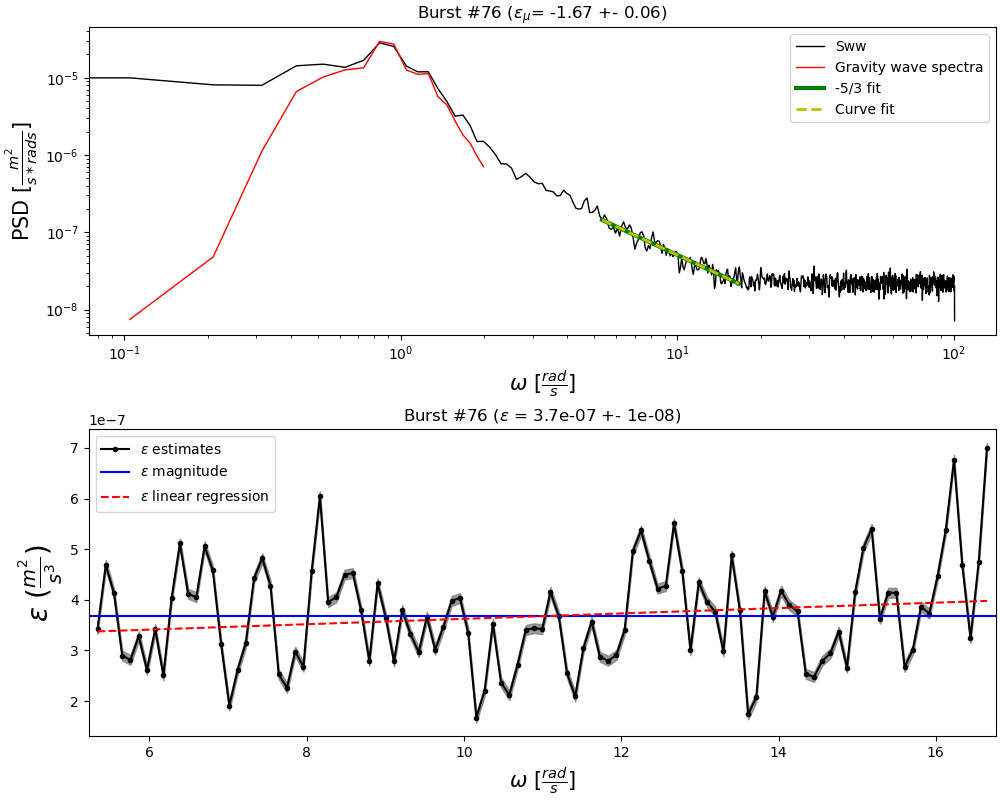

In [38]:
#Take a look at the specific burst we just estimated
epsSpectraPlotter(epsDS, 76, saveFig = False, filename = None)

In [326]:
def JlmIntegral(data):
    ds = data.copy(deep=True)
    burst_list = np.unique(ds.BurstNum.values)
    J_arr = np.empty((len(burst_list),3))
    
    # Initialize all variables theta, phi, and R within boundaries a to b
    phi = np.linspace(0, 2*np.pi, 1000)
    theta = np.linspace(0, np.pi, 1000)
    thetaRS = np.linspace(0, np.pi, 1000).reshape(1000,1)
    
    fTheta_11 = np.empty(len(theta)) # dims (burst, fPhi)
    fTheta_22 = np.empty(len(theta))
    fTheta_33 = np.empty(len(theta))
        
    for b in enumerate(burst_list):
        
        print('Burst #: '+str(b[1]))
        
        U = ds.Primary.where(ds.BurstNum.isin(b[1]), drop = True).values
        V = ds.Secondary.where(ds.BurstNum.isin(b[1]), drop = True).values
        W = ds.Up.where(ds.BurstNum.isin(b[1]), drop = True).values
    
        #Magnitude of current
        ubar = np.nanmean(np.sqrt(U**2))
        vbar = np.nanmean(np.sqrt(V**2))
        wbar = np.nanmean(np.sqrt(W**2))

        #Standard deviations
        usig = np.nanstd(U)
        vsig = np.nanstd(V) 
        wsig = np.nanstd(W) 
    
        #Variance
        uvar = usig**2
        vvar = vsig**2
        wvar = wsig**2

        # Find J_lm using method from Gerbi et al. (2009)
    
        R0 = ((ubar/usig) * (np.sin(thetaRS)*np.cos(phi))) + ((vbar/vsig) * (np.sin(thetaRS)*np.sin(phi)))
    
        G = np.sqrt((np.sin(thetaRS)**2) * (((np.cos(phi)/usig)**2) + ((np.sin(phi)/vsig)**2)) + ((np.cos(thetaRS)/wsig)**2))
    
        P_11 = (1/(G**2))*((((np.sin(thetaRS)**2)*(np.sin(phi)**2))/vvar)+((np.cos(thetaRS)**2)/wvar))
        P_22 = (1/(G**2))*((((np.sin(thetaRS)**2)*(np.cos(phi)**2))/uvar)+((np.cos(thetaRS)**2)/wvar))
        P_33 = ((np.sin(thetaRS)/G)**2) * (((np.cos(phi)/usig)**2) + ((np.sin(phi)/vsig)**2))
    
        fR = quad_vec(lambda R: (R**(2/3))*np.exp(-(((R0-R)**2)/2)), 0, 7)[0]
    
        fPhi_11 = (G**(-11/3))*np.sin(thetaRS)*P_11 * fR
        fPhi_22 = (G**(-11/3))*np.sin(thetaRS)*P_22 * fR
        fPhi_33 = (G**(-11/3))*np.sin(thetaRS)*P_33 * fR
    
        for i in enumerate(theta): # Iterates through theta values (the rows of the empty 2d arrays)

            fTheta_11[i[0]] = np.trapz(fPhi_11[i[0]], phi)
            fTheta_22[i[0]] = np.trapz(fPhi_22[i[0]], phi)
            fTheta_33[i[0]] = np.trapz(fPhi_33[i[0]], phi)
             
        # Evaluate the final integral of fTheta and use it to find J_lm    
        J_11 = (1/(2*((2*np.pi)**(3/2))))*(1/(usig*vsig*wsig)) * np.trapz(fTheta_11, theta)
        J_22 = (1/(2*((2*np.pi)**(3/2))))*(1/(usig*vsig*wsig)) * np.trapz(fTheta_22, theta)
        J_33 = (1/(2*((2*np.pi)**(3/2))))*(1/(usig*vsig*wsig)) * np.trapz(fTheta_33, theta)
        
        J_arr[b[0]] = [J_11,J_22,J_33]
        
    print('Creating Dataframe')
    JlmDF = pd.DataFrame(J_arr, index = burst_list, columns=['J_11', 'J_22', 'J_33'])
        
    return JlmDF

In [327]:
Jlm_int = JlmIntegral(ADVdata)
Jlm_int

Burst #: 76.0
Creating Dataframe


### Estimating wave height

Pressure spectrum attenuates from noise floor at higher frequencies.<BR>
Jones and Monosmith show that spectra can be modelled using tail of f^-4 after cutoff frequency (fc).<BR>
fc is 12 times the noise floor (W), and greater than 1.1 times the peak frequency (fp)

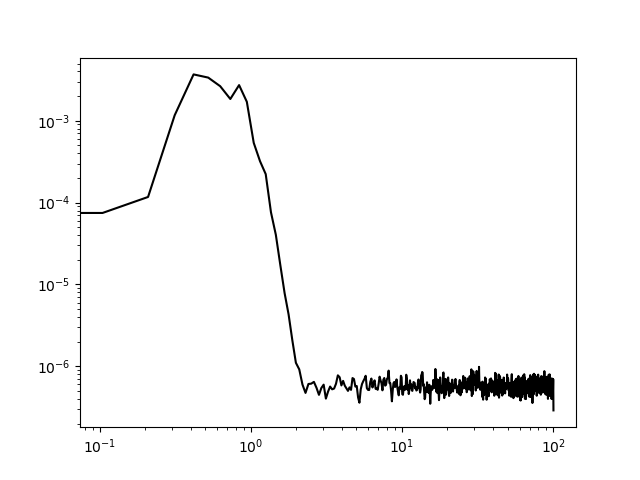

In [51]:
burstPressure_raw = ADVds.Pressure.sel(time=slice(burstTime[0],burstTime[-1]))
Fp_raw, Sp_raw = welch(burstPressure_raw, fs = fs, nperseg = nperseg, window='hann', detrend = 'linear') #Detrended pressure spectra
Sp_raw = Sp_raw/(2*np.pi)

plt.figure()
plt.loglog(omega, Sp_raw, '-k')

(0.5854811394932968, 0.8279953679850742, 6.029178796926469)